## Definitions

In [6]:
#matplotlib inline
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta, Adam, SGD
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Add, Input, GlobalAveragePooling2D, Activation, Concatenate
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from google.colab import drive
#drive.mount("/content/gdrive", force_remount=True)
#os.chdir("/content/gdrive/My Drive/Colab Notebooks") # might have to change path to point to your Colab Notebooks folder

## Load and format data

Number of classes: 10
Example of handwritten digit with correlated noise: 



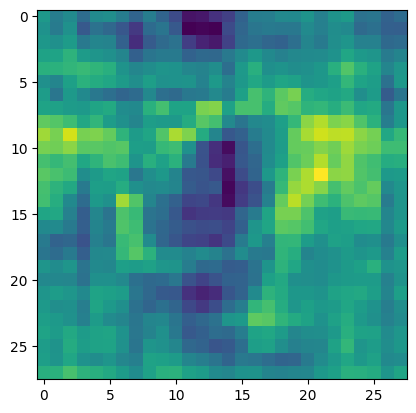

Class: 9

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [7]:
data = np.load('./MNIST_CorrNoise.npz')

x_train = data['x_train']
y_train = data['y_train']

num_cls = len(np.unique(y_train))
print('Number of classes: ' + str(num_cls))

print('Example of handwritten digit with correlated noise: \n')

k = 3000
plt.imshow(np.squeeze(x_train[k,:,:]))
plt.show()
print('Class: '+str(y_train[k])+'\n')

# RESHAPE and standarize
x_train = np.expand_dims(x_train/255,axis=3)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_cls)

print('Shape of x_train: '+str(x_train.shape))
print('Shape of y_train: '+str(y_train.shape))

## Training

In [8]:
model_name='CNN_5' # To compare models, you can give them different names

pweight='./weights/weights_' + model_name  + '.keras'

if not os.path.exists('./weights'):
  os.mkdir('./weights')

## EXPLORE VALUES AND FIND A GOOD SET
b_size = 3 # batch size
val_split = 0.2 # percentage of samples used for validation (e.g. 0.5)
ep = 20 # number of epochs

In [9]:
def inception_module(x, filters):
    """
    Inception module with multiple convolutional and pooling operations.
    """
    f1, f3_r, f3, f5_r, f5, pool_proj = filters

    # 1x1 Convolution
    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    # 1x1 Convolution followed by 3x3 Convolution
    conv3 = Conv2D(f3_r, (1, 1), padding='same', activation='relu')(x)
    conv3 = Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3)

    # 1x1 Convolution followed by 5x5 Convolution
    conv5 = Conv2D(f5_r, (1, 1), padding='same', activation='relu')(x)
    conv5 = Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5)

    # 3x3 MaxPooling followed by 1x1 Convolution
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(pool)

    # Concatenate all outputs
    return Concatenate()([conv1, conv3, conv5, pool])

## GoogleNet Inspired

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │      3,200 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 7, 7, 32)  │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 7, 7, 16)  │      1,040 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 7, 7, 32)  │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 7, 7, 64)  │     18,496 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 7, 7, 32)  │     12,832 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 7, 7, 32)  │      2,080 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 160) │          0 │ conv2d_8[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_10[0][0],  │
│                     │                   │            │ conv2d_12[0][0],  │
│                     │                   │            │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 4, 4, 160) │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 4, 4, 64)  │     10,304 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 4, 4, 32)  │      5,152 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 4, 4, 160) │          0 │ max_pooling2d_4[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 4, 4, 64)  │     10,304 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 4, 4, 128) │     73,856 │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 4, 4, 64)  │     51,264 │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 4, 4, 64)  │     10,304 │ max_pooling2d_5[

 Total params: 565,370 (2.16 MB)

 Trainable params: 565,242 (2.16 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
15996/16000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1086 - loss: 2.3302
Epoch 1: val_loss improved from inf to 2.30189, saving model to ./weights/weights_CNN_5.keras
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.1086 - loss: 2.3302 - val_accuracy: 0.1060 - val_loss: 2.3019
Epoch 2/20
15995/16000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1133 - loss: 2.3045
Epoch 2: val_loss did not improve from 2.30189
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.1133 - loss: 2.3045 - val_accuracy: 0.1060 - val_loss: 2.3029
Epoch 3/20
15994/16000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1152 - loss: 2.3014
Epoch 3: val_loss did not improve from 2.30189
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.1152 - loss: 2.3014 - val_accuracy: 0.1060 - val_loss: 2.3023
Epoch 4/20
15991/16000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1129 - loss: 2.3015
Epoch 4: val_loss did not improve from 2.30189
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 55s 3m

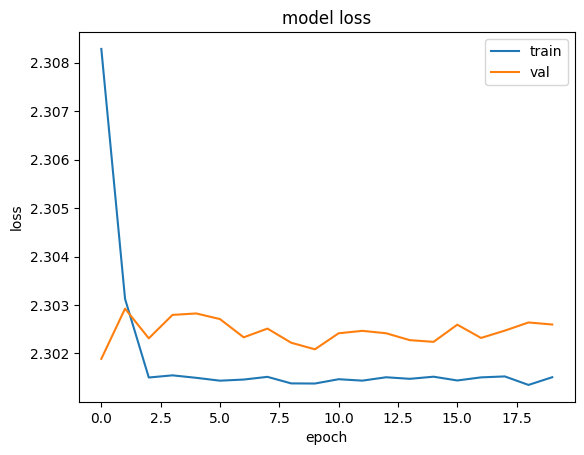

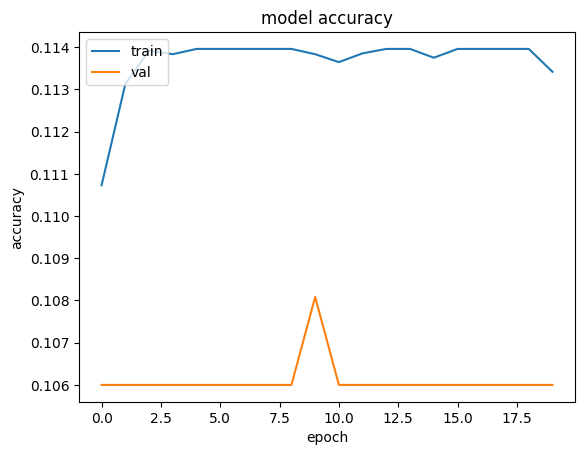

In [10]:
# Input Layer
input_layer = Input(shape=(28, 28, 1))

# Initial Convolutional and Pooling Layers
x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)  # Downsamples to (14, 14)
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)  # Downsamples to (7, 7)
x = BatchNormalization()(x)

# First Inception Module
x = inception_module(x, filters=[32, 32, 64, 16, 32, 32])  # Adjust filters for MNIST
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

# Second Inception Module
x = inception_module(x, filters=[64, 64, 128, 32, 64, 64])
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

# Flatten Feature Maps
x = Flatten()(x)

# Fully Connected Layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(10, activation='softmax')(x)  # 10 classes for MNIST

# Model
model = Model(input_layer, output_layer)

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

checkpointer = ModelCheckpoint(filepath=pweight, verbose=1, save_best_only=True)
callbacks_list = [checkpointer]

history = model.fit(x_train, y_train,
                    epochs=ep,
                    batch_size=b_size,
                    verbose=1,
                    shuffle=True,
                    validation_split=val_split,
                    callbacks=callbacks_list)

print('CNN_1 weights saved in ' + pweight)

# Plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Make predictions in test set

In [11]:
from keras.models import load_model

## LOAD DATA
data = np.load('./MNIST_CorrNoise.npz')

x_test = data['x_test']
y_test = data['y_test']

num_cls = len(np.unique(y_test))
print('Number of classes: ' + str(num_cls))

# RESHAPE and standarize
x_test = np.expand_dims(x_test/255,axis=3)

print('Shape of x_train: '+str(x_test.shape)+'\n')

model = load_model(pweight)
y_pred = model.predict(x_test)
# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_test is also in class indices (not one-hot encoded)
if len(y_test.shape) > 1:  # If y_test is one-hot encoded
    y_test = np.argmax(y_test, axis=1)

Acc_pred = sum(y_pred_classes == y_test) / len(y_test)
#Acc_pred = sum(y_pred == y_test)/len(y_test)

print('Accuracy in test set is: '+str(Acc_pred))


Number of classes: 10
Shape of x_train: (10000, 28, 28, 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy in test set is: 0.1135
